In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
%cd /gdrive/My Drive/ANNDL

/gdrive/My Drive/ANNDL


In [4]:
import tensorflow as tf
import numpy as np
import os
import random

In [5]:
tfk = tf.keras
tfkl = tf.keras.layers

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')

In [7]:
training_dir = './dataset/training'
validation_dir ='./dataset/validation'

# Images are divided into folders, one for each class.
# If the images are organized in such a way, we can exploit the
# ImageDataGenerator to read them from disk.
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

# Create an instance of ImageDataGenerator for training and validation sets
valid_data_gen = ImageDataGenerator()

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


In [8]:

epochs = 100

In [9]:
# Download and plot the model
supernet = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
)

473176280/473176280 [==============================] - 30s 0us/step


In [10]:
data_augmentation_layer = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.25),
  tf.keras.layers.RandomZoom(0.1),
], name='data_augmentation')

In [11]:
##VEDI VARIABILI
tl_model = tfk.Sequential([
    tfk.Input(shape=(96,96, 3), name='input_layer'),
    tfkl.Resizing(128, 128),
    data_augmentation_layer,
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet_v2.preprocess_input, name="supernet_preprocessing"),
    supernet,
    #tfkl.GlobalAveragePooling2D(),
    tfkl.Flatten(),
    tfkl.Dropout(0.7, seed=seed),
    tfkl.Dense(units=512, kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer=tfk.regularizers.l2(0.0001),activation='relu'),
    tfkl.Dropout(0.3, seed=seed),
    tfkl.Dense(units=256, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer=tfk.regularizers.l2(0.0001),activation='relu'),
    tfkl.Dropout(0.1, seed=seed),
    tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed),kernel_regularizer=tfk.regularizers.l2(0.0001), name='output_layer')
])

In [12]:
FT_MODEL_N_UNFREEZE = 1400
tl_model.get_layer(supernet.name).trainable = True

unfreezed = 0
for i in reversed(range(len(tl_model.get_layer(supernet.name).layers))):
  layer = tl_model.get_layer(supernet.name).layers[i]
  if layer.name == 'block6d_se_excite':
      layer.trainable = True
  elif unfreezed < FT_MODEL_N_UNFREEZE and not isinstance(layer, tf.keras.layers.BatchNormalization):
      unfreezed += 1
      layer.trainable = True
  else:
    layer.trainable = False

In [13]:
# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(), metrics='accuracy')
tl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 data_augmentation (Sequenti  (None, 128, 128, 3)      0         
 al)                                                             
                                                                 
 supernet_preprocessing (Lam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 efficientnetv2-l (Functiona  (None, 4, 4, 1280)       117746848 
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                        

In [14]:
class_weights = {0: 2.389358108108108,
                 1: 0.8320588235294117,
                 2: 0.8583131067961165,
                 3: 0.8667279411764706,
                 4: 0.8340212264150944,
                 5: 1.9978813559322033,
                 6: 0.8243006993006993,
                 7: 0.8709975369458128}

In [15]:
# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    class_weight=class_weights,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=40, restore_best_weights=True)]
).history

# Save the best model
tl_model.save('TransferLearningMode4')

Epoch 1/100
89/89 [==============================] - 2019s 22s/step - loss: 2.1581 - accuracy: 0.2149 - val_loss: 1.9829 - val_accuracy: 0.2875
Epoch 2/100
89/89 [==============================] - 62s 697ms/step - loss: 1.6779 - accuracy: 0.4192 - val_loss: 1.3338 - val_accuracy: 0.5288
Epoch 3/100
89/89 [==============================] - 62s 695ms/step - loss: 1.3866 - accuracy: 0.5553 - val_loss: 1.0129 - val_accuracy: 0.6746
Epoch 4/100
89/89 [==============================] - 61s 685ms/step - loss: 1.1432 - accuracy: 0.6568 - val_loss: 1.5419 - val_accuracy: 0.5161
Epoch 5/100
89/89 [==============================] - 63s 706ms/step - loss: 1.1340 - accuracy: 0.6614 - val_loss: 0.7769 - val_accuracy: 0.7686
Epoch 6/100
89/89 [==============================] - 61s 689ms/step - loss: 0.9513 - accuracy: 0.7243 - val_loss: 0.8616 - val_accuracy: 0.7153
Epoch 7/100
89/89 [==============================] - 62s 695ms/step - loss: 0.9116 - accuracy: 0.7409 - val_loss: 0.6838 - val_accuracy:

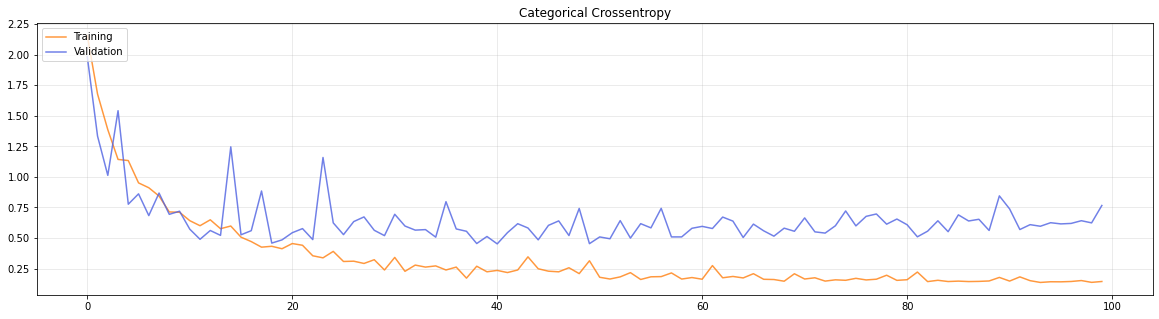

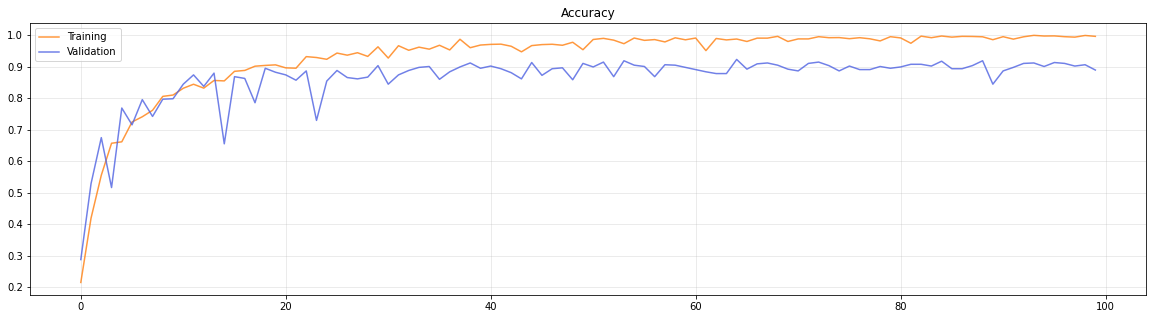

In [16]:
import matplotlib.pyplot as plt

# Plot the training
plt.figure(figsize=(20,5))
plt.plot(tl_history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(tl_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()